In [62]:
#pip uninstall numpy

In [63]:
#pip install --upgrade h5py

In [64]:
#pip install --upgrade tensorflow

### Implementation of Usecase from Yiyi's Benchmarking Paper
1. LW -> SIC (t+1) in JJA given heat flux (Laptav and East Siberian Sea (idx: 4+5))
2. LW(t-1) -> SIC  (-0.0251)
3. factor = 1 - 0.0251 


In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import Input
from tensorflow.keras.layers import Add, Lambda, Multiply, Activation, Dense, Dropout, Conv2D, ConvLSTM2D, Conv2DTranspose, BatchNormalization, UpSampling2D,MaxPooling2D, concatenate, Flatten, Reshape
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model, Model

2024-03-12 22:59:09.281300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Sea Ice Prediction - STCINet

### Loading Combined Data 1979-2021

Only consider last 5 variables

#### Features:
Original Order: sp, wind_speed, specific_humidity, t2m, shortwave, longwave, rain_rate, snow_rate, sst, sea_ice

We need: longwave, sea_ice

From other sources, we have: HFLX

In [2]:
whole_data = np.load('data/SIC_data/whole_data.npy',allow_pickle=True)
print(whole_data.shape)
land_mask = np.load("data/SIC_data/y_land_mask_actual.npy",allow_pickle=True)

(510, 448, 304, 10)


From other sources, we have: Sensible heat flux, Latent heat flux

In [3]:
import numpy as np
import netCDF4
from netCDF4 import Dataset
from tempfile import TemporaryFile

#Check Variable keys
file='data/SIC_data/ERA5_monthly_slhf_448x304_1979_2021.nc'
df=Dataset(file,'r')
print(df.variables.keys())

file2='data/SIC_data/ERA5_monthly_sshf_448x304_1979_2021.nc'
df2=Dataset(file2,'r')
print(df2.variables.keys())

dict_keys(['time', 'lon', 'lat', 'slhf'])
dict_keys(['time', 'lon', 'lat', 'sshf'])


In [4]:
slhf = np.array(df.variables['slhf'][:])
slhf = slhf[:510,:,:]
slhf = slhf.reshape(slhf.shape[0], slhf.shape[1], slhf.shape[2],1)

In [5]:
sshf = np.array(df2.variables['sshf'][:])
sshf = sshf[:510,:,:]
sshf = sshf.reshape(sshf.shape[0], sshf.shape[1], sshf.shape[2],1)

In [6]:
net_flux = slhf + sshf
print(net_flux.shape)

(510, 448, 304, 1)


In [39]:
#Concatenating all variables into one dataset

temp = whole_data[:,:,:,[-5,-1]]#LWDN and SIC
print(net_flux.shape, temp.shape)
data = np.concatenate([net_flux, temp], 3)
data.shape

(510, 448, 304, 1) (510, 448, 304, 2)


(510, 448, 304, 3)

In [68]:
#Enabling Dynamic Memory Allocation
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [40]:
#data = np.load('synthetic_spatiotemporal_data_with_spillover_3var.npy',allow_pickle=True)
#print(data.shape)


target = data[:,:,:,-1]
cov = data[:,:,:,:-1]

print(data.shape)
print(cov.shape)
print(target.shape)

(510, 448, 304, 3)
(510, 448, 304, 2)
(510, 448, 304)


In [41]:
#Adding a lag to target
lag = 1

data = data[1:-lag,:,:,:]
target = target[lag+1:,:,:]
cov = cov[:-(lag+1),:,:]

In [42]:
print(data.shape, cov.shape)
print(target.shape)

(508, 448, 304, 3) (508, 448, 304, 2)
(508, 448, 304)


In [43]:
## Shifting treatment to last column
#cov = data[:,:,:,:-1]
tr = data[:,:,:,1].copy() #LW
tr = tr.reshape(data.shape[0], data.shape[1], data.shape[2],1)
print(tr.shape)
print(data.shape)
data = np.delete(data, 1, 3)
print(data.shape)
data = np.concatenate([data, tr], 3)
print(data.shape)

(508, 448, 304, 1)
(508, 448, 304, 3)
(508, 448, 304, 2)
(508, 448, 304, 3)


In [44]:
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA
NUM_TEST = LEN_DATA

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)
print('NUM_TEST:',NUM_TEST)

x_train = data[:,:,:,:]
x_test = data[:,:,:,:] #[-NUM_TEST:]

#Create input2 of treatment and covariate history
x_train2 = cov[:,:,:,:]
x_test2 = cov[:,:,:,:] #[-NUM_TEST:]


#split features and labels
y_train=target[:,:,:] #target is last column
y_test=target[:,:,:] #[-NUM_TEST:] #target is last column

LEN_DATA: 508
NUM_TRAIN: 508
NUM_TEST: 508


In [45]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_train2.shape:',x_train2.shape)

print('x_test.shape:',x_test.shape)
print('x_test2.shape:',x_test2.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (508, 448, 304, 3)
y_train.shape: (508, 448, 304)
x_train2.shape: (508, 448, 304, 2)
x_test.shape: (508, 448, 304, 3)
x_test2.shape: (508, 448, 304, 2)
y_test.shape: (508, 448, 304)


In [46]:
#Replacing all nans with Zeros
x_train = np.nan_to_num(x_train)
x_train2 = np.nan_to_num(x_train2)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
x_test2 = np.nan_to_num(x_test2)
y_test = np.nan_to_num(y_test)

In [47]:
y_test[100]

array([[19., 19., 20., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Applying treatment at selective regions using regional mask

In [48]:
#loading regional mask
region_mask = np.load("data/SIC_data/NSIDC_25km_Arctic_Ocean_regional_landmask.npy")
print(region_mask.shape)
m_region_mask = np.tile(region_mask, (x_test.shape[0], 1, 1)) #turn mask into time-series
print(m_region_mask.shape)

(448, 304)
(508, 448, 304)


In [49]:
print(m_region_mask[1])

[[ 0  0  0 ... 30 30 30]
 [ 0  0  0 ... 30 30 30]
 [ 0  0  0 ... 30 30 30]
 ...
 [30 30 30 ...  0  0  0]
 [30 30 30 ...  0  0  0]
 [30 30 30 ...  0  0  0]]


### Treatment Cases
1. Case 1: SIC -> SLP (t+3) in DJF given GH (BK Sea (idx: 6+7)
2. Case 2: LW -> SIC (t+1) in JJA given GH (Laptav and East Siberian Sea (idx: 4+5))


In [54]:
#Update factor
#factor = 1 - 0.4 #SIC(t-3) -> SLP (-0.4)
factor = (1 - (2*0.025)) #LW(t-1) -> SIC (-0.251)
print(factor)


cond1 = m_region_mask > 3 #Laptav Sea
cond2 = m_region_mask < 6 #East Sea
idx = np.where(cond1 & cond2)

print(idx)

#idx2 = np.where(m_region_mask == 6)#Kara Sea
#idx3 = np.where(m_region_mask == 7) #Barents Sea

#x_treated = np.copy(x_test) #Whole Pan-Arctic
#x_treated[:,:,:,-1] = x_treated[:,:,:,-1]*1.1

lw = x_test[:,:,:,-1]
x_treated = np.copy(x_test) #Kara Sea
x_treated = np.delete(x_treated, -1, 3)
print(lw[1,:,:])

#Applying treatment to selective region
lw[idx] = lw[idx]*factor
lw = lw.reshape(x_test.shape[0], 448, 304, 1)
x_treated = np.concatenate([x_treated, lw], 3)
print(x_treated[1,:,:,-1])
print(x_treated.shape)


"""
sst = x_test[:,:,:,-1]
x_treated3 = np.copy(x_test) #Barents Sea
x_treated3 = np.delete(x_treated3, -1, 3)
print(x_treated3.shape)
sst[idx3] = sst[idx3]*1.1
sst = sst.reshape(86, 448, 304, 1)
x_treated3 = np.concatenate([x_treated3, sst], 3)
print(x_treated3.shape)


sst = x_test[:,:,:,-1]
x_treated4 = np.copy(x_test) #Chukchi Sea
x_treated4 = np.delete(x_treated4, -1, 3)
print(x_treated4.shape)
sst[idx4] = sst[idx4]*1.1
sst = sst.reshape(86, 448, 304, 1)
x_treated4 = np.concatenate([x_treated4, sst], 3)
print(x_treated4.shape)
"""

0.95
(array([  0,   0,   0, ..., 507, 507, 507]), array([150, 151, 151, ..., 200, 200, 201]), array([159, 159, 160, ..., 177, 178, 178]))
[[337.89324951 337.89324951 337.89324951 ... 209.5067749  209.5067749
  215.30401611]
 [337.89324951 337.89324951 337.89324951 ... 209.5067749  209.36132812
  209.36132812]
 [338.68392944 337.89324951 335.74221802 ... 209.36132812 209.36132812
  209.36132812]
 ...
 [301.84378052 301.84378052 296.52044678 ... 316.22561646 316.22561646
  316.22561646]
 [301.84378052 301.84378052 302.31091309 ... 316.22561646 316.22561646
  316.22561646]
 [301.84378052 301.84378052 302.31091309 ... 316.22561646 316.22561646
  319.51846313]]
[[337.89324951 337.89324951 337.89324951 ... 209.5067749  209.5067749
  215.30401611]
 [337.89324951 337.89324951 337.89324951 ... 209.5067749  209.36132812
  209.36132812]
 [338.68392944 337.89324951 335.74221802 ... 209.36132812 209.36132812
  209.36132812]
 ...
 [301.84378052 301.84378052 296.52044678 ... 316.22561646 316.22561646

'\nsst = x_test[:,:,:,-1]\nx_treated3 = np.copy(x_test) #Barents Sea\nx_treated3 = np.delete(x_treated3, -1, 3)\nprint(x_treated3.shape)\nsst[idx3] = sst[idx3]*1.1\nsst = sst.reshape(86, 448, 304, 1)\nx_treated3 = np.concatenate([x_treated3, sst], 3)\nprint(x_treated3.shape)\n\n\nsst = x_test[:,:,:,-1]\nx_treated4 = np.copy(x_test) #Chukchi Sea\nx_treated4 = np.delete(x_treated4, -1, 3)\nprint(x_treated4.shape)\nsst[idx4] = sst[idx4]*1.1\nsst = sst.reshape(86, 448, 304, 1)\nx_treated4 = np.concatenate([x_treated4, sst], 3)\nprint(x_treated4.shape)\n'

In [52]:
print(lw[40,131,101], x_test[40,131,101,-1], x_treated[40,131,101,-1])

[278.81106567] 278.8110656738281 278.8110656738281


### Reshaping Input and Target Features

In [55]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, samples, timestep, lat, lon, features):
    print(dataset.shape)
    X = dataset.reshape(samples, timestep, lat, lon, features)
    return X

# convert an array of values into a dataset matrix
def reshape_outcome(dataset, months, lat, lon):
    print(dataset.shape)
    X = dataset.reshape(months, lat, lon, 1)
    return X

### Normalization

In [56]:
# normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[-1])) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[-1])) #reshaping to 2d for standard scaling
x_treated = scaler_f.transform(x_treated.reshape(-1,x_treated.shape[-1])) #reshaping to 2d for standard scaling

scaler_h = StandardScaler()
x_train2 = scaler_h.fit_transform(x_train2.reshape(-1,x_train2.shape[-1])) #reshaping to 2d for standard scaling
x_test2 = scaler_h.transform(x_test2.reshape(-1,x_test2.shape[-1])) #reshaping to 2d for standard scaling
#x_treated2 = scaler_h.transform(x_treated2.reshape(-1,x_treated2.shape[-1])) #reshaping to 2d for standard scaling


scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling


In [57]:
print('x_train.shape:',x_train.shape)
print('x_train2.shape:',x_train2.shape)
print('y_train.shape:',y_train.shape)

print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (69185536, 3)
x_train2.shape: (69185536, 2)
y_train.shape: (69185536, 1)
x_test.shape: (69185536, 3)
y_test.shape: (69185536, 1)


In [58]:
y_test[:1]

array([[0.27901499]])

In [59]:
#Reshaping data to 3D for modeling
lat = 448
lon = 304
features = 3 #actual features
features2 = 2 #history
timestep = 1

x_train = reshape_features(x_train, NUM_TRAIN, timestep, lat, lon, features) # reshaping to 3d for model
x_test = reshape_features(x_test, NUM_TRAIN, timestep, lat, lon, features) # reshaping to 3d for model
x_treated = reshape_features(x_treated, NUM_TRAIN, timestep, lat, lon, features) #reshaping to 2d for standard scaling

x_train2 = reshape_features(x_train2, NUM_TRAIN, timestep, lat, lon, features2) # reshaping to 3d for model
x_test2 = reshape_features(x_test2, NUM_TRAIN, timestep, lat, lon, features2) # reshaping to 3d for model
#x_treated2 = reshape_features(x_treated2, NUM_TRAIN, timestep, lat, lon, features2) # reshaping to 3d for model

y_train = reshape_outcome(y_train, NUM_TRAIN, lat, lon) # reshaping to 3d for model
y_test = reshape_outcome(y_test, NUM_TRAIN, lat, lon) # reshaping to 3d for model

(69185536, 3)
(69185536, 3)
(69185536, 3)
(69185536, 2)
(69185536, 2)
(69185536, 1)
(69185536, 1)


In [60]:
print('x_train.shape:',x_train.shape)
print('x_train2.shape:',x_train2.shape)
print('y_train.shape:',y_train.shape)

print('x_test.shape:',x_test.shape)
print('x_test2.shape:',x_test2.shape)
print('x_treated.shape:',x_treated.shape)
#print('x_treated2.shape:',x_treated2.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (508, 1, 448, 304, 3)
x_train2.shape: (508, 1, 448, 304, 2)
y_train.shape: (508, 448, 304, 1)
x_test.shape: (508, 1, 448, 304, 3)
x_test2.shape: (508, 1, 448, 304, 2)
x_treated.shape: (508, 1, 448, 304, 3)
y_test.shape: (508, 448, 304, 1)


In [30]:
input1_shape = (timestep, lat, lon, features2)
input2_shape = (timestep, lat, lon, features)

filter_size=3
use_temp_scaling=False
n_output_classes=1
#loss = tf.keras.losses.MeanSquaredError() #custom_mse
metrics = RootMeanSquaredError()
print(input1_shape, input2_shape)

(1, 448, 304, 2) (1, 448, 304, 3)


2024-03-12 23:09:35.331834: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [31]:
import tensorflow.keras.backend as K

def expend_as(tensor, rep):

    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2

    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                       arguments={'repnum': rep})(tensor)
    return my_repeat

def AttnGatingBlock(x, g, inter_shape):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)
    print('shape_x, shape_g',shape_x, shape_g)

    #upsample_g = UpSampling2D(size=(2,2))(g)

    # Getting the gating signal to the same shape and number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=3,
                   strides=1,
                   padding='same')(g)#(upsample_g)

    print('K.int_shape(phi_g)',K.int_shape(phi_g))

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=1,
                     #strides=(shape_x[1] // shape_g[1],
                              #shape_x[2] // shape_g[2]),
                     padding='same')(x)
    print('K.int_shape(theta_x)',K.int_shape(theta_x))

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)
    print('shape_sigmoid',shape_sigmoid)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1],
                                             shape_x[2] //
                                             shape_sigmoid[2]))(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expend_as(upsample_sigmoid_xg, shape_x[3])
    print('K.int_shape(upsample_sigmoid_xg)',K.int_shape(upsample_sigmoid_xg))

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=shape_x[3],
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization()(output)
    print('output',K.int_shape(output))
    return output

In [32]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, concatenate, Activation, Multiply, Add, Lambda, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Permute
import tensorflow as tf

def spatial_attention_module(input_tensor):
    """Generate a spatial attention map and multiply it by the input tensor."""
    # Average pooling and max pooling
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)
    concat = concatenate([avg_pool, max_pool], axis=-1)

    # Convolution layer to generate the attention map
    attention = Conv2D(filters=1, kernel_size=(7, 7), padding='same', activation='sigmoid')(concat)

    # Multiply the input tensor by the attention map
    output_tensor = Multiply()([input_tensor, attention])
    return output_tensor


In [33]:
    input1 = Input(shape=input1_shape)
    input2 = Input(shape=input2_shape)

    #LFM Block-----start---------
    convlstm1 = ConvLSTM2D(8, (5,5), padding="same", return_sequences=False, data_format="channels_last")(input1)
    conv = Conv2D(np.int(16), filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(convlstm1)
    drop = Dropout(0.2)(conv)
    conv = Conv2D(np.int(16), (1,1), activation='relu', padding='same', kernel_initializer='he_normal')(drop)
    bn = BatchNormalization(axis=-1)(conv)
    print('K.int_shape(drop)',K.int_shape(drop))
    out = Flatten()(bn)
    out = Dense (64, activation = "relu")(out)
    out = Dense(lat*lon, activation = "linear")(out)
    out = Reshape((lat, lon, 1), input_shape=(28*28,), name="lfm_output")(out)

    #LFM Block-----end---------

    #Merge LFM Block with input-----------
    convlstm2 = ConvLSTM2D(8, (5,5), padding="same", return_sequences=False, data_format="channels_last")(input2)
    print('K.int_shape(convlstm2)',K.int_shape(convlstm2))
    merge0 = concatenate([conv,convlstm2], axis=3)
    print('K.int_shape(merge0)',K.int_shape(merge0))

    #UNet-----start-----------
    conv1 = Conv2D(32, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge0)
    conv1 = Conv2D(32, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    attn0 = spatial_attention_module(conv1)
    bn1 = BatchNormalization(axis=-1)(attn0)
    print('K.int_shape(bn1)',K.int_shape(bn1))
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    attn1 = spatial_attention_module(conv2)
    bn2 = BatchNormalization(axis=-1)(attn1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    bn3 = BatchNormalization(axis=-1)(conv3)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2), interpolation='nearest')(bn3))
    attn2 = AttnGatingBlock(up8, bn2, 64)
    merge8 = concatenate([up8, attn2], axis=3)
    conv8 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    bn8 = BatchNormalization(axis=-1)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2), interpolation='nearest')(bn8))
    attn3 = AttnGatingBlock(up9, bn1, 32)
    merge9 = concatenate([up9, attn3], axis=3)
    conv9 = Conv2D(32, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(32, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(32, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    #UNet-----end-----------

    output = Conv2D(n_output_classes, 1, activation='linear', name="unet_output")(conv9)

    model = Model(inputs = [input1, input2], outputs = [out, output])

/tmp/ipykernel_14189/4193684194.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conv = Conv2D(np.int(16), filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(convlstm1)
/tmp/ipykernel_14189/4193684194.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

K.int_shape(drop) (None, 448, 304, 16)
K.int_shape(convlstm2) (None, 448, 304, 8)
K.int_shape(merge0) (None, 448, 304, 24)
K.int_shape(bn1) (None, 448, 304, 32)
shape_x, shape_g (None, 224, 152, 64) (None, 224, 152, 64)
K.int_shape(phi_g) (None, 224, 152, 64)
K.int_shape(theta_x) (None, 224, 152, 64)
shape_sigmoid (None, 224, 152, 1)
K.int_shape(upsample_sigmoid_xg) (None, 224, 152, 64)
output (None, 224, 152, 64)
shape_x, shape_g (None, 448, 304, 32) (None, 448, 304, 32)
K.int_shape(phi_g) (None, 448, 304, 32)
K.int_shape(theta_x) (None, 448, 304, 32)
shape_sigmoid (None, 448, 304, 1)
K.int_shape(upsample_sigmoid_xg) (None, 448, 304, 32)
output (None, 448, 304, 32)


In [34]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

In [35]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)#tf.keras.ops.exp(-0.1)

In [36]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 448, 304  0           []                               
                                , 2)]                                                             
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 448, 304, 8)  8032        ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 304, 16  1168        ['conv_lstm2d[0][0]']            
                                )                                                                 
                                                                                              

In [37]:

loss = 'mse' #RootMeanSquaredError()
loss_weights = [0.25, 0.75]
metrics = RootMeanSquaredError()

model.compile(optimizer=Adam(), loss=loss, loss_weights = loss_weights, metrics = metrics)

In [38]:
#Try this block
# define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
# fit model
print(x_train.shape, y_train.shape)
history = model.fit(x=[x_train2, x_train], y=[x_train2, y_train],epochs=60,batch_size=4,callbacks = [callback],validation_split=.2,verbose = 2)

#				callbacks=[early_stopping])

(508, 1, 448, 304, 3) (508, 448, 304, 1)
Epoch 1/60
102/102 - 443s - loss: 0.4830 - lfm_output_loss: 1.3480 - unet_output_loss: 0.1947 - lfm_output_root_mean_squared_error: 1.1618 - unet_output_root_mean_squared_error: 0.4413 - val_loss: 0.5857 - val_lfm_output_loss: 1.0064 - val_unet_output_loss: 0.4455 - val_lfm_output_root_mean_squared_error: 1.0046 - val_unet_output_root_mean_squared_error: 0.6675 - lr: 0.0010 - 443s/epoch - 4s/step
Epoch 2/60
102/102 - 456s - loss: 11.4262 - lfm_output_loss: 45.4431 - unet_output_loss: 0.0873 - lfm_output_root_mean_squared_error: 6.7494 - unet_output_root_mean_squared_error: 0.2954 - val_loss: 20.2589 - val_lfm_output_loss: 80.0559 - val_unet_output_loss: 0.3266 - val_lfm_output_root_mean_squared_error: 8.9523 - val_unet_output_root_mean_squared_error: 0.5715 - lr: 0.0010 - 456s/epoch - 4s/step
Epoch 3/60
102/102 - 456s - loss: 3.6009 - lfm_output_loss: 14.2079 - unet_output_loss: 0.0653 - lfm_output_root_mean_squared_error: 3.7737 - unet_output_r

KeyboardInterrupt: 

In [79]:
#train = model.evaluate([x_train,x_train2], [x_train2,y_train])
#print("Train MSE: {:.4f}\nTrain Loss: {:.4f}".format(train_mse, train_loss))

#test = model.evaluate([x_test2,x_test], [x_test2,y_test])
#print("Test MSE: {:.4f}\nTest Loss: {:.4f}".format(test_mse, test_loss))

16/16 [==============================] - 208s 13s/step - loss: 0.2543 - lfm_output_loss: 0.8869 - unet_output_loss: 0.0434 - lfm_output_root_mean_squared_error: 0.9419 - unet_output_root_mean_squared_error: 0.2083


In [61]:
_, y_pred = model.predict([x_test2,x_test])
_, y_pred_cf = model.predict([x_test2,x_treated])
print(y_pred.shape, y_pred_cf.shape)

16/16 [==============================] - 109s 7s/step
(508, 448, 304, 1) (508, 448, 304, 1)


In [62]:
#print(cf_data[10,1,10:20], inv_y_pred_cf[10,1,10:20])
print(y_pred_cf.min(), y_pred_cf.max())
print(y_pred.min(), y_pred.max())
print(y_test.min(), y_test.max())

-0.95697933 3.5829163
-0.95697933 3.5829163
-0.38241120872224044 3.0987793264273646


In [63]:
# invert scaling for forecasted values
inv_y_pred = scaler_l.inverse_transform(y_pred.reshape(-1,1))
inv_y_pred_cf = scaler_l.inverse_transform(y_pred_cf.reshape(-1,1))

# invert scaling for actual values
inv_y_test = scaler_l.inverse_transform(y_test.reshape(-1,1))

In [64]:
print(inv_y_pred_cf.min(), inv_y_pred_cf.max())
print(inv_y_pred.min(), inv_y_pred.max())
print(inv_y_test.min(), inv_y_test.max())

-16.504932 113.90722
-16.504932 113.90722
0.0 100.0


In [65]:
inv_y_pred = inv_y_pred.reshape(len(y_pred),lat, lon)
print(inv_y_pred.shape)
inv_y_pred_cf = inv_y_pred_cf.reshape(len(y_pred_cf),lat, lon)
print(inv_y_pred_cf.shape)
inv_y_test = inv_y_test.reshape(len(y_test),lat, lon)
print(inv_y_pred.shape)

(508, 448, 304)
(508, 448, 304)
(508, 448, 304)


In [66]:
inv_y_test[1,1,1]- inv_y_pred[1,1,1]

-1.3323073387145996

In [67]:
inv_y_test[1,1,1]- inv_y_pred_cf[1,1,1]

-1.3323073387145996

In [68]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_test.flatten(), inv_y_pred.flatten()))
print('Test RMSE: %.3f' % rmse)

#rmse1 = sqrt(mean_squared_error(cf_data[1:].flatten(), inv_y_pred_cf.flatten()))
#print('Treated RMSE: %.3f' % rmse1)

Test RMSE: 6.601


In [69]:
post_y = np.clip(inv_y_pred, a_min = 0, a_max = 100)
with open("data/stcinet_predy_lw_sic_lag1_v2.npy", "wb") as f:
  np.save(f, post_y)
post_y_cf = np.clip(inv_y_pred_cf, a_min = 0, a_max = 100)
with open("data/stcinet_predcf_lw_sic_lag1_v2.npy", "wb") as f:
  np.save(f, post_y_cf)
post_y_test = np.clip(inv_y_test, a_min = 0, a_max = 100)
with open("data/stcinet_test_lw_sic_lag1_v2.npy", "wb") as f:
  np.save(f, post_y_test)

In [70]:
ts = post_y_cf.shape[0]
real_ts = np.array([np.mean(post_y_test[i,:,:]) for i in range(ts)])
pred_ts = np.array([np.mean(post_y[i,:,:]) for i in range(ts)])
cf_ts = np.array([np.mean(post_y_cf[i,:,:]) for i in range(ts)])
print(real_ts.shape)

(508,)


Text(0, 0.5, 'Outcome(Y)')

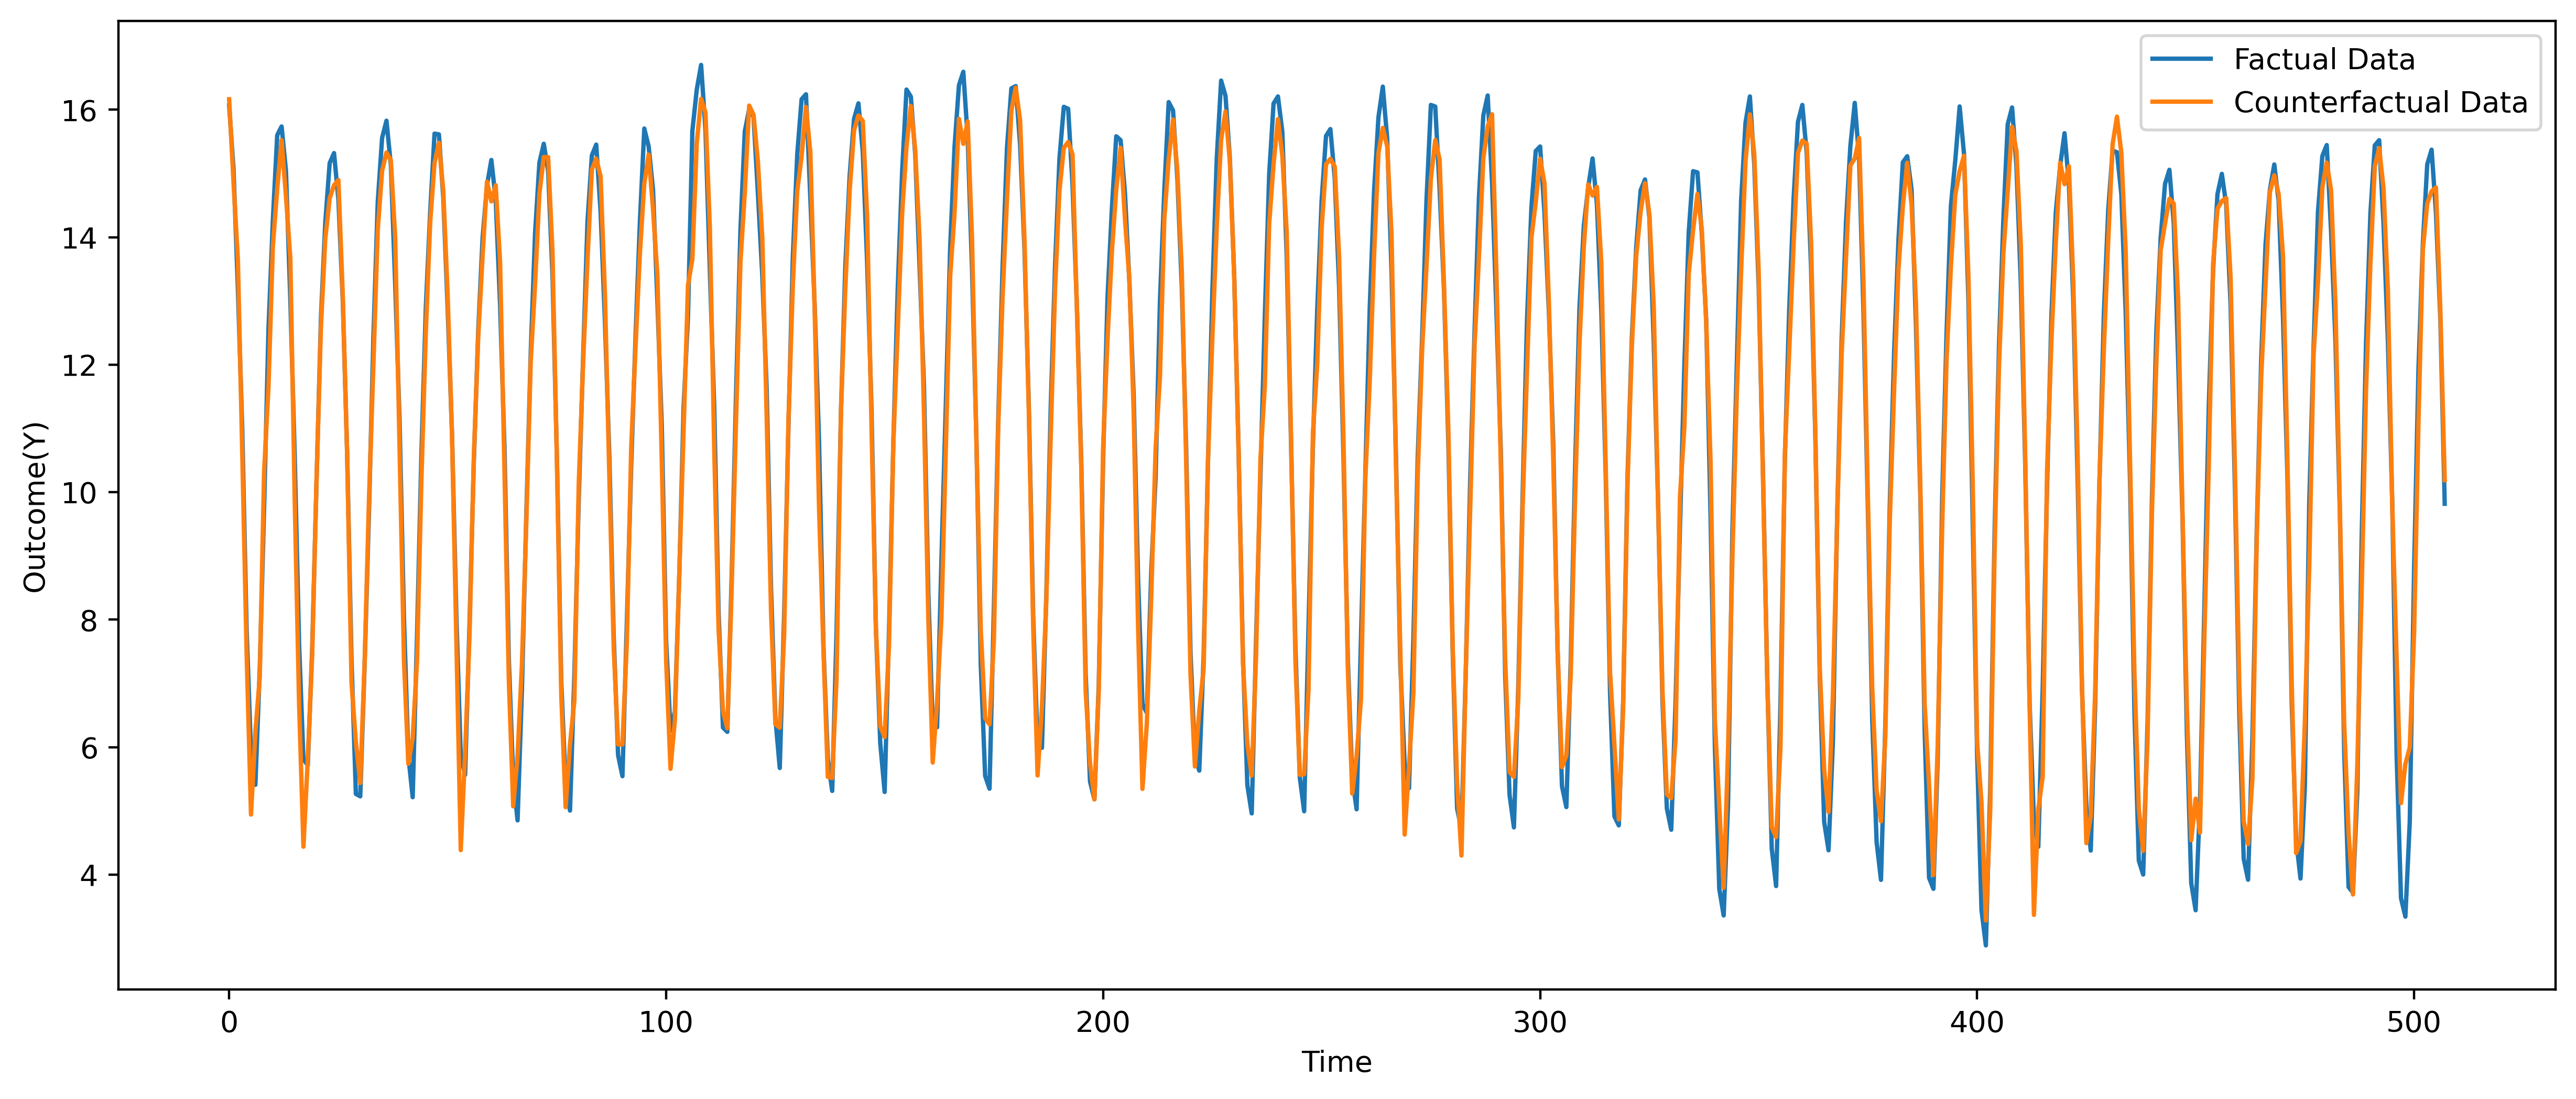

In [72]:
fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),real_ts, label = "Factual Data")
ax.plot(range(ts),cf_ts, label = "Counterfactual Data")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")

Text(0, 0.5, 'Outcome(Y)')

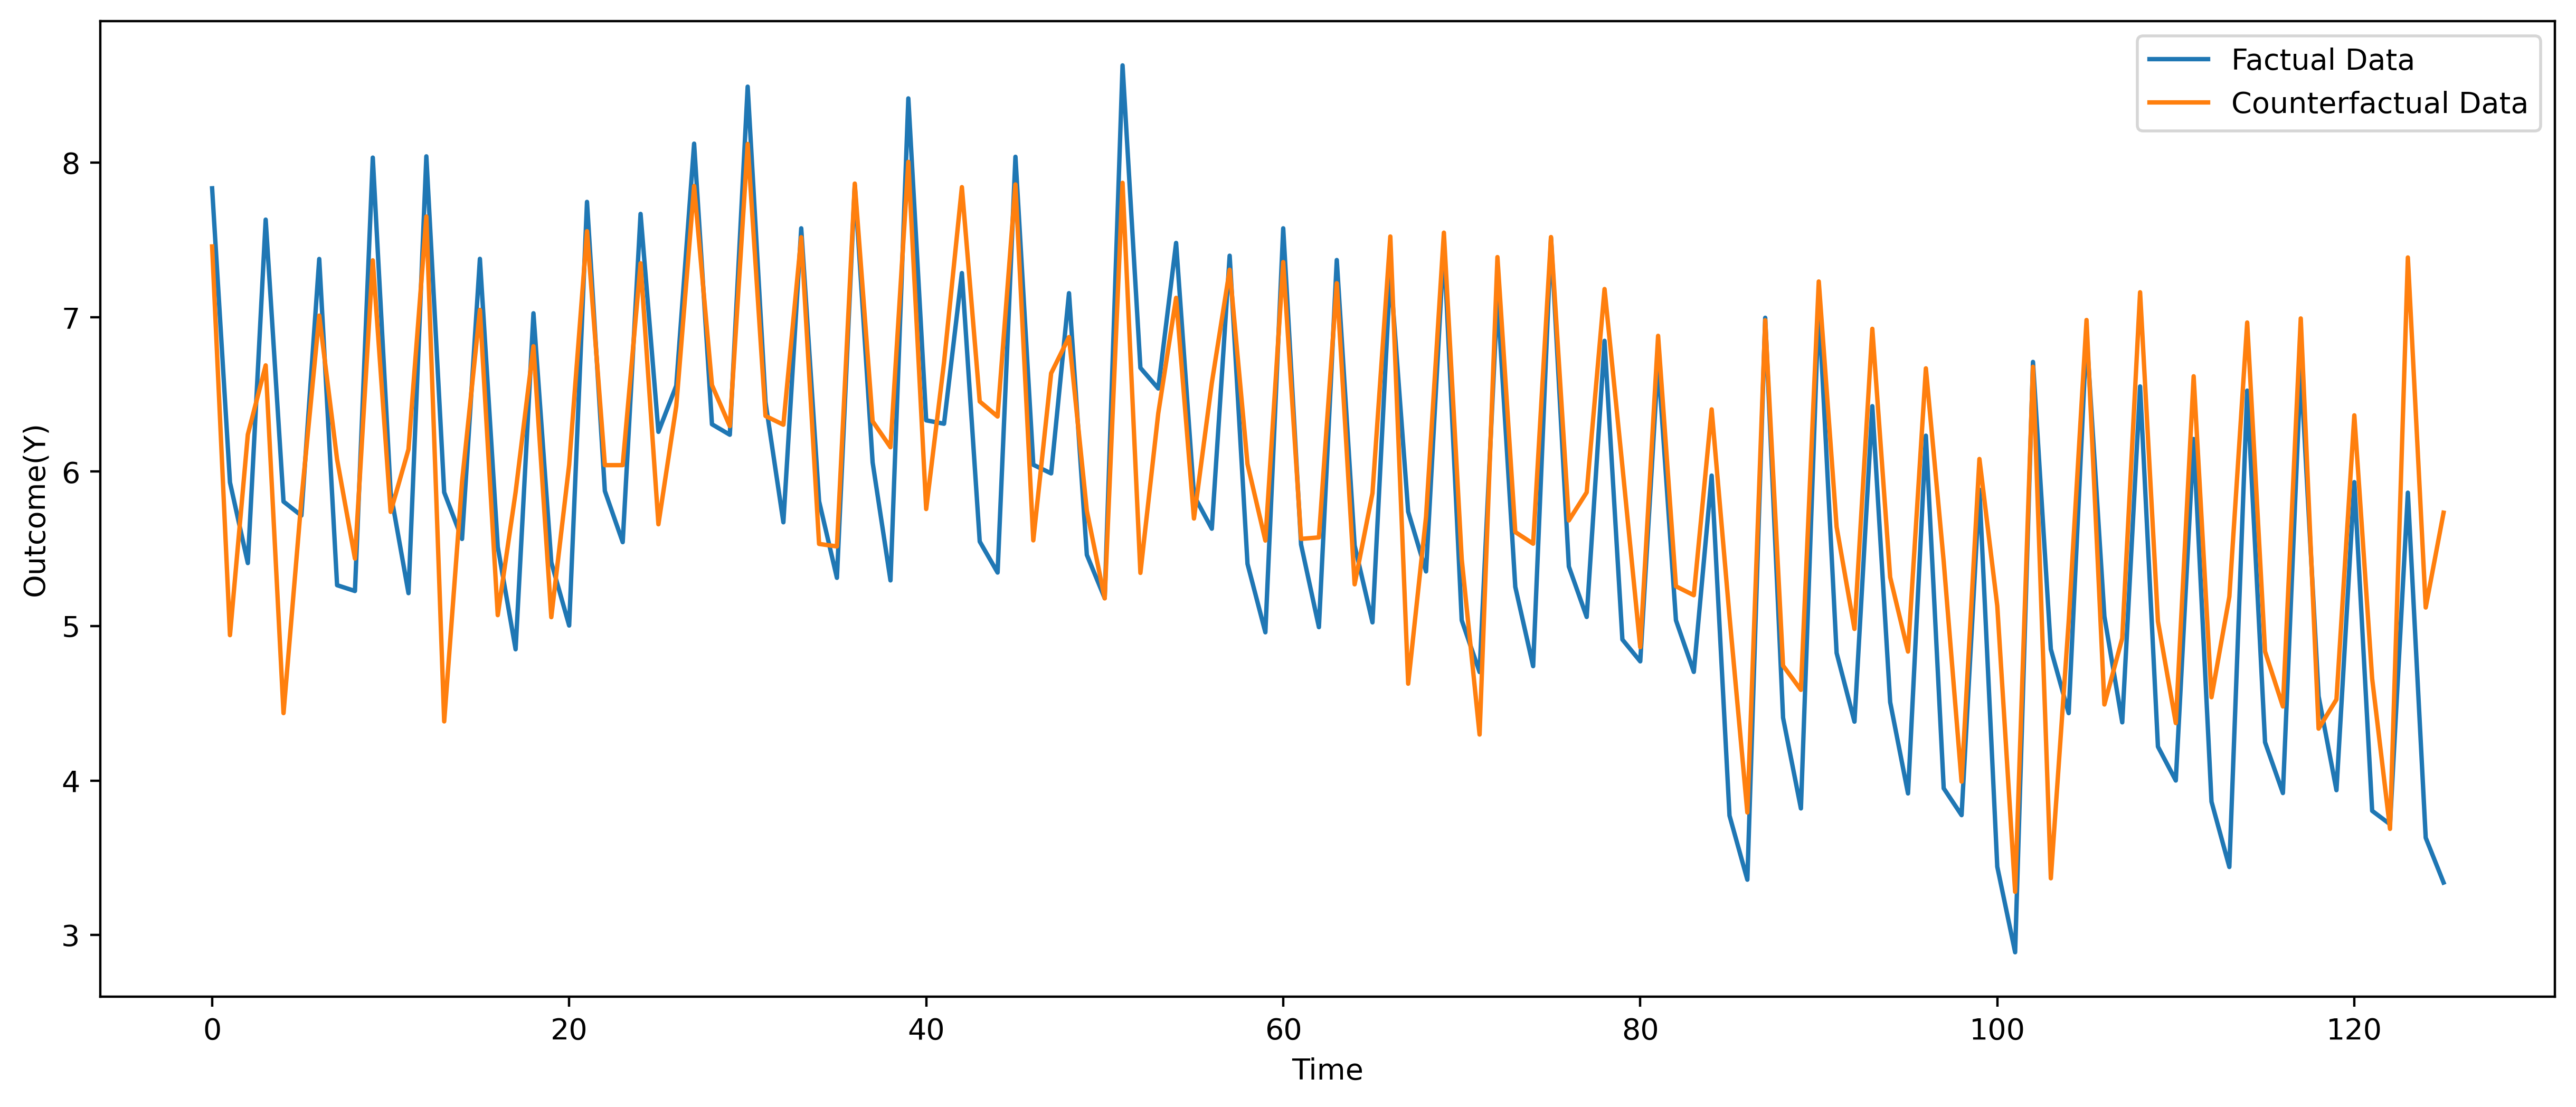

In [81]:
ts = len(summer_real)

fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),summer_real, label = "Factual Data")
ax.plot(range(ts),summer_cf, label = "Counterfactual Data")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")

In [77]:
print(pred_ts.shape)
june = real_ts[4::12]
july = real_ts[5::12]
aug = real_ts[6::12]
print(june.shape)
print(july.shape)
print(aug.shape)
summer_real = np.concatenate((june.reshape(-1,1),july.reshape(-1,1),aug.reshape(-1,1)),1)

#print(summer_pred)
summer_real = summer_real.flatten()

(508,)
(42,)
(42,)
(42,)


In [79]:
print(cf_ts.shape)
june_cf = cf_ts[4::12]
july_cf = cf_ts[5::12]
aug_cf = cf_ts[6::12]
print(june.shape)
print(july.shape)
print(aug.shape)
summer_cf = np.concatenate((june_cf.reshape(-1,1),july_cf.reshape(-1,1),aug_cf.reshape(-1,1)),1)

#print(summer_pred)
summer_cf = summer_cf.flatten()

(508,)
(42,)
(42,)
(42,)


In [80]:
ate = np.mean(cf_ts - real_ts)
print("Estimated ATE for all years:",ate)

summer_ate = np.mean(summer_cf - summer_real)
print("Estimated ATE for JJA:",summer_ate)

Estimated ATE for all years: -0.08918425933671413
Estimated ATE for JJA: 0.22666975116678603


In [82]:
#loading regional mask for East Siberian and Laptav Sea
region_mask = np.load("data/SIC_data/NSIDC_25km_Arctic_Ocean_regional_mask.npy")
print(region_mask.shape)
cond1 = region_mask > 3
cond2 = region_mask < 6
el_mask = np.where(cond1 & cond2, 1, 0)
#m_region_mask = np.tile(region_mask, (x_test.shape[0], 1, 1)) #turn mask into time-series
print(el_mask.max())

(448, 304)
1


In [83]:
#Regional Prediction for DATE

mask_ts = np.tile(el_mask, (inv_y_pred_cf.shape[0], 1, 1)) #turn mask into time-series
mask_ts.shape

(508, 448, 304)

In [84]:
cf_el = np.multiply(inv_y_pred_cf, mask_ts)
real_el = np.multiply(inv_y_test, mask_ts)

In [85]:
ts = inv_y_pred.shape[0]
real_el_ts = np.array([np.mean(real_el[i,:,:]) for i in range(ts)])
cf_el_ts = np.array([np.mean(cf_el[i,:,:]) for i in range(ts)])

In [86]:
el_ate = np.mean(cf_el_ts - real_el_ts)
print("Estimated ATE for East Siberian and Laptav Sea:",el_ate)

Estimated ATE for East Siberian and Laptav Sea: 0.045525493264724576


Summer within East Siberian and Laptav Sea

In [87]:
june = real_el_ts[4::12]
july = real_el_ts[5::12]
aug = real_el_ts[6::12]
print(june.shape)
print(july.shape)
print(aug.shape)
summer_el_real = np.concatenate((june.reshape(-1,1),july.reshape(-1,1),aug.reshape(-1,1)),1)

#print(summer_pred)
summer_el_real = summer_el_real.flatten()

(42,)
(42,)
(42,)


In [88]:
june_el_cf = cf_el_ts[4::12]
july_el_cf = cf_el_ts[5::12]
aug_el_cf = cf_el_ts[6::12]
summer_el_cf = np.concatenate((june_el_cf.reshape(-1,1),july_el_cf.reshape(-1,1),aug_el_cf.reshape(-1,1)),1)

#print(summer_pred)
summer_el_cf = summer_el_cf.flatten()

In [89]:
summer_el_ate = np.mean(summer_el_cf - summer_el_real)
print("Estimated JJA ATE for East Siberian and Laptav Sea:",summer_el_ate)

Estimated JJA ATE for East Siberian and Laptav Sea: 0.4440556545245226
